<a href="https://colab.research.google.com/github/gnsJhenJie/petalClassification/blob/main/transformer_pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer
Created on: Mar 27, 2022

## Imports


In [1]:
!pip install transformers huggingface-hub

     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 
     |████████████████████████████████| 596 kB 13.6 MB/s 
     |████████████████████████████████| 880 kB 41.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5e2068ef0bee0b307bb0748cafad1307844848151b4b1292cc358e1c6b9bc7d1
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# data analysis tool
import math, re, os
import numpy as np
import pandas as pd
import random

# tensorflow for keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


## Setup strategy using TPU/GPU

In [3]:
# tf.config.set_visible_devices([], 'CPU') # hide the CPU
# tf.config.set_visible_devices(gpus[1], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
# strategy = tf.distribute.MirroredStrategy(devices=["GPU:3"])
print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.118.72.154:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.118.72.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.72.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Load data

In [4]:
import glob
IMAGE_SIZE = [224, 224]
GCS_PATH = 'gs://kds-2e84f4868fca298a64de3b466302235cf717ea327ea1b91d15f1d205/tfrecords-jpeg-224x224'
# from kaggledatasets import KaggleDatasets

# GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# print(GCS_DS_PATH) # what do gcs paths look like?
AUTO = tf.data.experimental.AUTOTUNE # read from multiple files if possible

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Data augmentation

In [5]:
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers

# 5eps loss: 1.6562 - accuracy: 0.9492 - top-3-accuracy: 0.9830 - val_loss: 1.7469 - val_accuracy: 0.9098 - val_top-3-accuracy: 0.9674 test: 0.79985
# model_id = "google/vit-base-patch16-224-in21k" 

# 5eps loss: 2.0305 - accuracy: 0.8546 - top-3-accuracy: 0.9497 - val_loss: 2.1052 - val_accuracy: 0.8190 - val_top-3-accuracy: 0.9370 test: 0.62743 (submission5.csv)
# model_id = 'google/vit-base-patch32-224-in21k'

# model_id = 'google/vit-huge-patch14-224-in21k'

# model_id = 'google/vit-base-patch16-224'

# loss: 0.0745 - accuracy: 0.9969 - top-3-accuracy: 0.9994 - val_loss: 0.2214 - val_accuracy: 0.9658 - val_top-3-accuracy: 0.9863 test: 0.96293 (submission6.csv)
# model_id = "google/vit-large-patch16-224-in21k" 

# loss: 0.7089 - accuracy: 0.9766 - top-3-accuracy: 0.9932 - val_loss: 0.8442 - val_accuracy: 0.9391 - val_top-3-accuracy: 0.9776
model_id = 'google/vit-large-patch32-224-in21k'


feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
SEED = 2025

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        # set up the erase block
        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

    
def data_augment_v2(image, label):
    print(type(image))
    print(image)
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
    image = tf.image.resize(image,[feature_extractor.size, feature_extractor.size])
    image = tf.transpose(image, [2, 0, 1])
#     image = feature_extractor(images=image.numpy(), return_tensors="tf")
    #image = random_blockout(image)
    
    return image, label
def data_augment_v3(image, label):
    image = tf.transpose(image, [2, 0, 1])
    
    return image, label

## Overview dataset
[Keras Image Classification with Vision Transfomer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)


In [7]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment_v2, num_parallel_calls=AUTO)
    # dataset = dataset.map(data_augment_v3, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.map(data_augment_v3, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(data_augment_v3, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
# Define the batch size.
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# 12G的GPU設16差不多  原本64
BATCH_SIZE = 32

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("args_0:0", shape=(224, 224, 3), dtype=float32)
Training: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(32, 3, 224, 224) (32,)
(32, 3, 224, 224) (32,)
(32, 3, 224, 224) (32,)
Training data label examples: [ 40  67 102 ...  11  73   9]


In [10]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(32, 3, 224, 224) (32,)
(32, 3, 224, 224) (32,)
(32, 3, 224, 224) (32,)
Test data IDs: ['7b1773554' '38c7f43d6' 'ed4b21055' ... '9e07d0aad' 'a73af3677' '74973ce69']


## Explore data

In [11]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [12]:
# ds_iter = iter(ds_train.unbatch().batch(20))

In [13]:
# one_batch = next(ds_iter)
# display_batch_of_images(one_batch)

# Transformer

In [14]:
num_classes = len(CLASSES)
input_shape = (224,224,3)

## Load pretrained model

## Hyperparameter

In [15]:
from huggingface_hub import HfFolder
import tensorflow as tf

# id2label = {str(i): label for i, label in enumerate(img_class_labels)}
# label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = BATCH_SIZE
eval_batch_size = BATCH_SIZE
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
# hub_model_id = f'{model_id.split("/")[1]}-euroSat'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
# if fp16:
#     tf.keras.mixed_precision.set_global_policy("mixed_float16")

## Download the pretrained model and finetune it

In [16]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // train_batch_size
# create optimizer wight weigh decay
num_train_steps = STEPS_PER_EPOCH * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)
with strategy.scope():
    # load pre-trained ViT model
    model = TFViTForImageClassification.from_pretrained(
        model_id,
        num_labels=num_classes,
    #     id2label=id2label,
    #     label2id=label2id,
    )

    # define loss
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # define metrics 
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ]

    # compile model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics
                  )

Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Some layers from the model checkpoint at google/vit-large-patch32-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch32-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))

In [18]:
# model.summary()
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:
model.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  305510400 
                                                                 
 classifier (Dense)          multiple                  106600    
                                                                 
Total params: 305,617,000
Trainable params: 305,617,000
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.layers[0].trainable = False

In [21]:
train_results = model.fit(
    ds_train,
    validation_data=ds_valid,
    # callbacks=callbacks, # TPU callback要註解掉
    epochs=num_train_epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
)

Epoch 1/5
398/398 [==============================] - 223s 218ms/step - loss: 3.3705 - accuracy: 0.5162 - top-3-accuracy: 0.6702 - val_loss: 2.4054 - val_accuracy: 0.7977 - val_top-3-accuracy: 0.9227
Epoch 2/5
398/398 [==============================] - 67s 168ms/step - loss: 1.8770 - accuracy: 0.8634 - top-3-accuracy: 0.9522 - val_loss: 1.5143 - val_accuracy: 0.8917 - val_top-3-accuracy: 0.9663
Epoch 3/5
398/398 [==============================] - 67s 169ms/step - loss: 1.1877 - accuracy: 0.9370 - top-3-accuracy: 0.9820 - val_loss: 1.0912 - val_accuracy: 0.9270 - val_top-3-accuracy: 0.9766
Epoch 4/5
398/398 [==============================] - 67s 169ms/step - loss: 0.8659 - accuracy: 0.9638 - top-3-accuracy: 0.9896 - val_loss: 0.9177 - val_accuracy: 0.9348 - val_top-3-accuracy: 0.9795
Epoch 5/5
398/398 [==============================] - 67s 169ms/step - loss: 0.7189 - accuracy: 0.9750 - top-3-accuracy: 0.9935 - val_loss: 0.8621 - val_accuracy: 0.9356 - val_top-3-accuracy: 0.9795


In [22]:
test_ds = get_test_dataset(ordered=True)
print(test_ds)
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)

probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities['logits'], axis=-1)
print(predictions)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>
Computing predictions...
[ 67  28  83 ... 103 102  62]


In [23]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,70
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


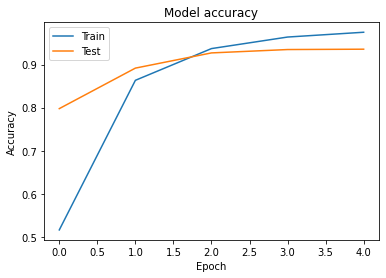

In [24]:
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

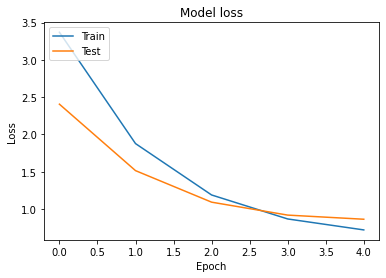

In [25]:
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()